<h2>Introduction</h2>

<p>Xgboost on clinvar dataset.</p>
<p>Classes are Pathogenic vs Non-Pathogenic</p>

<h3> Load Libraries </h3>

In [35]:
import time
import numpy as np; print('numpy Version:', np.__version__)
import pandas as pd; print('pandas Version:', pd.__version__)
import sklearn; print('Scikit-Learn Version:', sklearn.__version__)
import xgboost as xgb; print('XGBoost Version:', xgb.__version__)
from pathlib import Path
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

numpy Version: 1.18.1
pandas Version: 0.25.3
Scikit-Learn Version: 0.21.3
XGBoost Version: 1.0.2


<h3> Load Data </h3>

In [36]:
# Specify data path where datasets are placed
data_dir = Path('./data')

# Read dataset
data = pd.read_csv(data_dir / 'clinvar_filtered',sep = "\t")

<h3> Convert Classes to Pathogenic(1) or Non-Pathogenic(0) </h3>

In [37]:
# Extract classes
Y = data['CLNSIG']
# Drop first column which is meaningless
X_raw = data.drop(data.columns[0], axis=1)
# Drop classes column
X_raw = X_raw.drop(data.columns[1], axis=1)
# Convert all entries which are not Pathogenic to Non-Pathogenic
Y.loc[Y != "Pathogenic"] = "Non-Pathogenic"
# Assign Pathogenic=1 and Non-Pathogenic=0
Y = Y.replace(to_replace=['Pathogenic', 'Non-Pathogenic'], value=[1, 0])

<h3> Convert String Attributes to Numeric Categorial Attributes </h3>

In [38]:
# LabelEncoder to convert String Attributes to Numeric for column 'ANN[0].EFFECT'
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(X_raw['ANN[0].EFFECT'])
X_raw['ANN[0].EFFECT'] = le.transform(X_raw['ANN[0].EFFECT'])

<h3> Fill NaNs with Mean of that column </h3>

In [39]:
# Fill NA's with Mean of the column
X_raw['dbNSFP_Polyphen2_HVAR_score'].fillna(value=X_raw['dbNSFP_Polyphen2_HVAR_score'].mean(),inplace=True)
X_raw['dbNSFP_Polyphen2_HDIV_score'].fillna(value=X_raw['dbNSFP_Polyphen2_HDIV_score'].mean(),inplace=True)
X_raw['dbNSFP_LRT_score'].fillna(value=X_raw['dbNSFP_LRT_score'].mean(),inplace=True)
X_raw['CADD'].fillna(value=X_raw['CADD'].mean(),inplace=True)
X_raw['dbNSFP_phastCons20way_mammalian'].fillna(value=X_raw['dbNSFP_phastCons20way_mammalian'].mean(),inplace=True)
X_raw['dbNSFP_LRT_Omega'].fillna(value=X_raw['dbNSFP_LRT_Omega'].mean(),inplace=True)
X_raw['dbNSFP_MutationTaster_score'].fillna(value=X_raw['dbNSFP_MutationTaster_score'].mean(),inplace=True)
X_raw['dbNSFP_VEST3_score'].fillna(value=X_raw['dbNSFP_VEST3_score'].mean(),inplace=True)
X_raw['dbNSFP_DANN_score'].fillna(value=X_raw['dbNSFP_DANN_score'].mean(),inplace=True)
X_raw['dbNSFP_MetaSVM_score'].fillna(value=X_raw['dbNSFP_MetaSVM_score'].mean(),inplace=True)
X_raw['dbNSFP_MetaLR_score'].fillna(value=X_raw['dbNSFP_MetaLR_score'].mean(),inplace=True)
X_raw['dbNSFP_integrated_fitCons_score'].fillna(value=X_raw['dbNSFP_integrated_fitCons_score'].mean(),inplace=True)
X_raw['dbNSFP_GM12878_fitCons_score'].fillna(value=X_raw['dbNSFP_GM12878_fitCons_score'].mean(),inplace=True)
X_raw['Eigenraw'].fillna(value=X_raw['Eigenraw'].mean(),inplace=True)
X_raw['gnomAD_AF'].fillna(value=X_raw['gnomAD_AF'].mean(),inplace=True)

<h3> Normalize Data </h3>

In [40]:
# Normalize data
X = (X_raw - X_raw.min()) / (X_raw.max() - X_raw.min())
# Convert Data into Numpy array
X = X.to_numpy()
X = X.copy('C')

<h3> Split data into train/test </h3>

In [41]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y)

<h3> Convert NumPy data to DMatrix format for XGboost </h3>

In [42]:
%%time
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalidation = xgb.DMatrix(X_test, label=Y_test)

CPU times: user 89.9 ms, sys: 2.88 ms, total: 92.8 ms
Wall time: 171 ms


<h3>Set XGBoost Parameters </h3>

In [43]:
# instantiate params
params = {}
classification = True
# general params
general_params = {'silent': 1}
params.update(general_params)

# booster params
n_gpus = 1  # change this to -1 to use all GPUs available or 0 to use the CPU
booster_params = {}

if n_gpus != 0:
    booster_params['tree_method'] = 'gpu_hist'
    booster_params['n_gpus'] = n_gpus   
params.update(booster_params)

# learning task params
learning_task_params = {}
if classification:
    learning_task_params['eval_metric'] = 'auc'
    learning_task_params['objective'] = 'binary:hinge'
else:
    learning_task_params['eval_metric'] = 'rmse'
    learning_task_params['objective'] = 'reg:squarederror'
params.update(learning_task_params)

<h3>Train Model</h3>

In [44]:
# model training settings
evallist = [(dvalidation, 'validation'), (dtrain, 'train')]
num_round = 300

In [ ]:
%%time
bst = xgb.train(params, dtrain, num_round, evallist)

<h3>Predict on test data </h3>

In [46]:
y_pred = bst.predict(dvalidation)

<h3> Confusion Matrix </h3>

In [47]:
print(confusion_matrix(Y_test,y_pred))

[[48030  3017]
 [ 3521  6665]]


<h3> Generate Classification Report </h3>

In [48]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     51047
           1       0.69      0.65      0.67     10186

    accuracy                           0.89     61233
   macro avg       0.81      0.80      0.80     61233
weighted avg       0.89      0.89      0.89     61233



<h3> Calculate Accuracy Store </h3>

In [49]:
print(accuracy_score(Y_test,y_pred))

0.8932275080430487


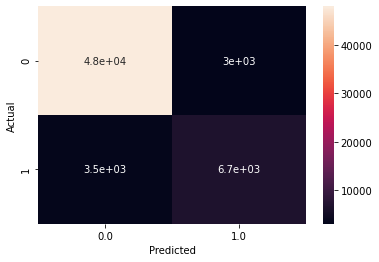

In [51]:
%matplotlib inline
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':    Y_test,
        'y_Predicted': y_pred
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()